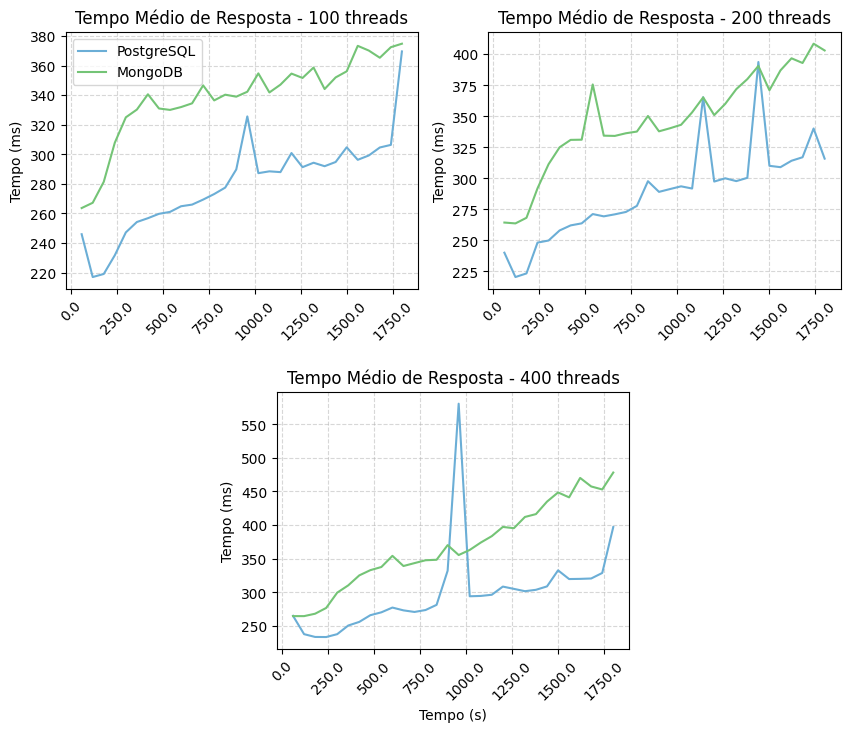

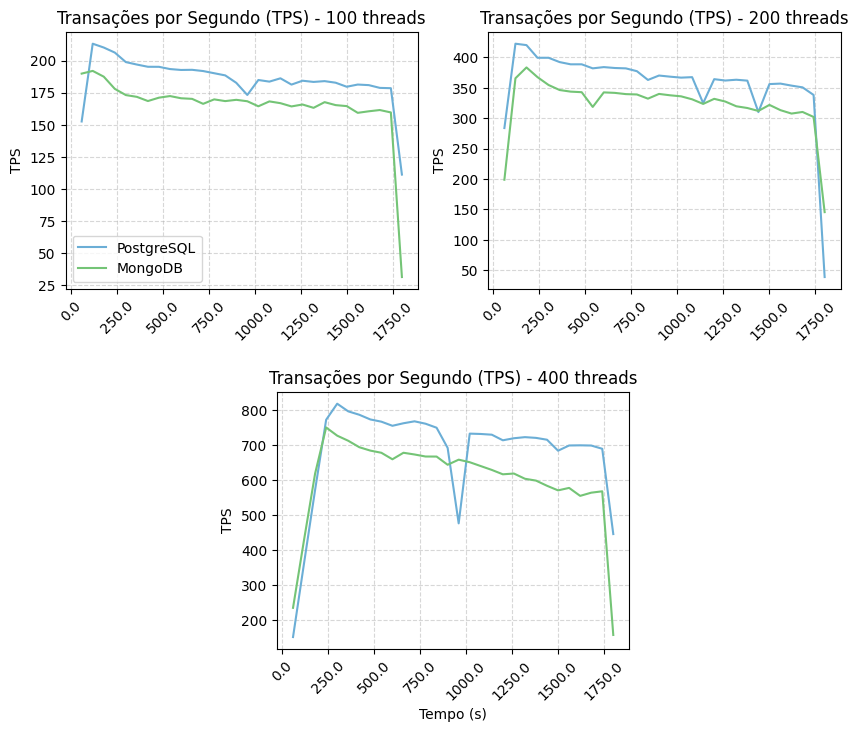

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import numpy as np
import os

# === CONFIGURAÇÕES ===
workload = 'mixed'
scenarios = {
    '100': '60',
    '200': '120',
    '400': '240'
}

db_pg = 'pg'
db_mongo = 'mongo'
pg_color = '#6baed6'
mongo_color = '#74c476'

output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# === FUNÇÃO PARA CARREGAR MÉTRICAS ===
def load_metrics(threads, ramp):
    pg_path = f'output/{db_pg}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'
    mongo_path = f'output/{db_mongo}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'

    df_pg = pd.read_csv(pg_path)
    df_mongo = pd.read_csv(mongo_path)

    df_pg['timeStamp'] = pd.to_datetime(df_pg['timeStamp'], unit='ms')
    df_mongo['timeStamp'] = pd.to_datetime(df_mongo['timeStamp'], unit='ms')

    df_pg.set_index('timeStamp', inplace=True)
    df_mongo.set_index('timeStamp', inplace=True)

    response_pg = df_pg['elapsed'].resample('1T').mean()
    response_mongo = df_mongo['elapsed'].resample('1T').mean()
    tpm_pg = df_pg['elapsed'].resample('1T').count()
    tpm_mongo = df_mongo['elapsed'].resample('1T').count()
    tps_pg = tpm_pg / 60
    tps_mongo = tpm_mongo / 60

    # converte o índice para segundos
    response_pg.index = (response_pg.index - response_pg.index[0]).total_seconds()
    response_mongo.index = (response_mongo.index - response_mongo.index[0]).total_seconds()
    tps_pg.index = (tps_pg.index - tps_pg.index[0]).total_seconds()
    tps_mongo.index = (tps_mongo.index - tps_mongo.index[0]).total_seconds()

    return response_pg, response_mongo, tps_pg, tps_mongo

# === PLOT COM GRÁFICO DE BAIXO CENTRALIZADO, TOPO COMPACTO ===
def plot_uniform_metric(title, ylabel, extract_fn, filename_prefix):
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.4, wspace=0.2)

    ax1 = fig.add_subplot(gs[0, 0])  # 100 threads
    ax2 = fig.add_subplot(gs[0, 1])  # 200 threads
    ax3 = fig.add_subplot(gs[1, 0])  # 400 threads
    fig.delaxes(fig.add_subplot(gs[1, 1]))  # Remove gráfico extra

    # centraliza o de baixo manualmente entre os dois de cima
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    width = pos1.width
    center = (pos1.x0 + pos2.x1) / 2
    ax3.set_position([center - width / 2, pos1.y0 - 0.45, width, pos1.height])

    axs = [ax1, ax2, ax3]
    threads_order = ['100', '200', '400']

    for i, threads in enumerate(threads_order):
        ramp = scenarios[threads]
        r_pg, r_m, t_pg, t_m = load_metrics(threads, ramp)
        y_pg, y_m = extract_fn(r_pg, r_m, t_pg, t_m)

        y_pg = y_pg[y_pg.index > 20]
        y_m = y_m[y_m.index > 20]

        ax = axs[i]
        ax.plot(y_pg.index, y_pg.values, label='PostgreSQL', color=pg_color)
        ax.plot(y_m.index, y_m.values, label='MongoDB', color=mongo_color)
        ax.set_title(f'{title} - {threads} threads')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))

        if i == 0:
            ax.legend()

    axs[2].set_xlabel('Tempo (s)')

    plt.savefig(f'{output_dir}/{filename_prefix}_{workload}_uniforme.png', dpi=300)
    plt.show()
    plt.close()

# === EXECUÇÃO FINAL ===

# Gráfico: Tempo Médio de Resposta
plot_uniform_metric(
    title='Tempo Médio de Resposta',
    ylabel='Tempo (ms)',
    extract_fn=lambda r_pg, r_m, t_pg, t_m: (r_pg, r_m),
    filename_prefix='tempo_resposta'
)

# Gráfico: TPS
plot_uniform_metric(
    title='Transações por Segundo (TPS)',
    ylabel='TPS',
    extract_fn=lambda r_pg, r_m, t_pg, t_m: (t_pg, t_m),
    filename_prefix='tps'
)
